In [21]:
import numpy as np
from keras.datasets import mnist
import pandas as pd

# Importing the dataset and preprocessing to get it in the desired shape
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255
temp = X_train.reshape(60000,28*28).T
temp = temp.reshape(28,28,1,60000)
temp = temp[:,:,:,:1000]
ytemp = y_train[:1000]

temp1 = X_test.reshape(10000,28*28).T
temp1 = temp1.reshape(28,28,1,10000)
temp1 = temp1[:,:,:,:1000]
ytemp1 = y_test[:1000]

In [22]:
# Flatten function is used to convert a convoluted matrix into a single array
# to apply in FC layer
def flatten(X):
    shape_x=X.shape[0]
    shape_y=X.shape[1]
    shape_z=X.shape[2]
    m=X.shape[3]
    flattened_vec = X.reshape(shape_x*shape_y*shape_z,m)
    return flattened_vec,shape_x,shape_y,shape_z,m

In [23]:
# Zero-pad function is to do padding of the input matrix to minimize data loss
def zero_pad(X, pad):
    
    X_pad = np.pad(X, ((pad,pad),(pad,pad),(0,0)), 'constant', constant_values=0)
    return X_pad

In [24]:
# Softmax function is used in the final step
def softmax(x):
    softm = np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)
    return softm

In [25]:
# Relu function is used as activation function in the convolution layers
def relu(x):
    y= np.maximum(0,x)
    return y

In [26]:
# The gradient of relu function
def relugradient(dact,act):
    dhidden = dact
    dhidden[act<=0]=0
    return dhidden    

In [27]:
# conv_forward function is to apply convolution on the input using filters
def conv_forward(X,W,filtbias,padding=0,stride=1):       
    p = int(padding)
    if (padding is not 0):
        X = np.pad(X, ((p,p),(p,p),(0,0)), 'constant')
    n = int(X.shape[0])
    #print(n)
    m = int(X.shape[3])
   # print(m)
    f = int(W.shape[0])
    #print(f)
    s = int(stride)
    #print(s)
    num_channels=int(X.shape[2])
    num_filters=W.shape[3]
    if (type((n-f+2*p)//s) is not int):
        print((n-f+2*p)//s)
        print('invalid padding or stride')
        return
    #output_size = int((n-f+2*p)/s) +1
    output_size = int((n-f)/s) + 1
    #print(output_size)
    Z = np.zeros((output_size,output_size,num_filters,m))
    for k in range(num_filters):
        for i in range(output_size):
            for j in range(output_size):
                Z[i,j,k,:]=np.sum(X[i*s:(i*s+f),j*s:(j*s+f),:,:]*W[:,:,:,k].reshape(f,f,num_channels,-1),axis=(0,1,2)) + filtbias[:,:,k,:]
                
    return Z

In [28]:
def cnn_pool_forward(X,f=2,stride=2):       
    n = int(X.shape[0])
    m = int(X.shape[3])
    s = int(stride)
    num_filters=int(X.shape[2])
    output_size = int((n-f)/s) +1
    Z = np.zeros((output_size,output_size,num_filters,m))
    for k in range(num_filters):
        for i in range(output_size):
            for j in range(output_size):
                Z[i,j,k,:]=np.max(X[i*s:(i*s+f),j*s:(j*s+f),k,:],axis=(0,1))                
    return Z

In [29]:
def conv_backward(dZ,W,X,stride=1):
    '''
    The backward computation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to output of the conv layer (Z), numpy array of shape (n_H, n_W) 
    W -- weights of the conv layer
    X -- input of the conv layer
    
    Returns:
    dX -- gradient of the cost with respect to input of the conv layer (X), numpy array of shape (n_H_prev, n_W_prev) 
    dfilter -- gradient of the cost with respect to the weights of the conv layer (W), numpy array of shape (f,f) 
    '''
    # Retrieving dimensions from W's shape
    (f, f, num_channels,num_filters) = W.shape
    
    # Retrieving dimensions from dZ's shape
    (n_H, n_W,_,_) = dZ.shape
    
    s=stride
    
    # Initializing dX, dW with the correct shapes
    dfilter = np.zeros(W.shape)
    dX = np.zeros(X.shape)
    dbias = np.zeros((1,1,num_filters,1))
    m = X.shape[3]
    # Looping over vertical(h) and horizontal(w) axis of the output
    for k in range(num_filters):
        # To eliminate the looping over each training example,
        # we create a 5-dim filter matrix where the filter matrix is repeated along the 5th dim
        shapedfilter=np.tile(W[:,:,:,k].reshape(f,f,num_channels,1),(1,1,1,1,m))[0]
        for h in range(n_H):
            for w in range(n_W):
                dX[h*s:h*s+f, w*s:w*s+f,:,:] += shapedfilter * dZ[h,w,k,:]
                dfilter[:,:,:,k] += np.sum(X[h*s:h*s+f, w*s:w*s+f,:,:] * dZ[h,w,k,:],axis=3)
                dbias[:,:,k,:] += np.sum(dZ[h,w,k,:])
                #print(X[h:h+f, w:w+f,:].shape)
    return dfilter,dbias,dX

In [30]:
def cnn_pool_backward(dA_pooled,A_act,f=2,stride=2):
    dA_act = np.zeros(A_act.shape)
    s = stride
    (n_H,n_W,n_C,_)=dA_pooled.shape
    dA_pooled_reshape=np.repeat(np.repeat(dA_pooled,[f],axis=1),[f],axis=0)
    for c in range(n_C):
        for h in range(n_H):
            for w in range(n_W):
                #print(h,w)
                mask = (A_act[h*s:h*s+f,w*s:w*s+f,c,:]==np.max(A_act[h*s:h*s+f,w*s:w*s+f,c,:],axis=(0,1)))
                #print(mask[:,:,0])
                dA_act[h*s:h*s+f,w*s:w*s+f,c,:]=dA_pooled_reshape[h*s:h*s+f,w*s:w*s+f,c,:]*mask                   
    return dA_act

In [31]:
def calculate_loss(y,y_prob):
    loss_train=0
    m = y.shape[0]
    for i in np.arange(m):
        loss_train = loss_train+ (-np.log(y_prob[i,y[i]]))
    loss_train = loss_train/m
    return loss_train

In [32]:
def accuracy_score(y,y_prob):
    pred=pd.DataFrame(y_prob).idxmax(axis=1)
    return np.mean(pred==y)

In [33]:
def tell_size(temp,ytemp,myfilter1,myfilter2,filt1bias,filt2bias):
    feat_map = conv_forward(temp,myfilter1,filt1bias,stride=1)
    feat_map_act = relu(feat_map)
    feat_map_pool = cnn_pool_forward(feat_map_act,f=2,stride=2)
    feat_map2= conv_forward(feat_map_pool,myfilter2,filt2bias,stride=1)
    feat_map2_act=relu(feat_map2)
    flattened_vec,shape_x,shape_y,shape_z,m = flatten(feat_map2_act)
    return flattened_vec.shape[0]


In [34]:
def forward_propagate(temp,ytemp,parameters,fc1_neurons,num_class):
    (myfilter1,myfilter2,filt1bias,filt2bias,W1,W2,b1,b2)=parameters
    feat_map = conv_forward(temp,myfilter1,filt1bias,stride=1)
    
    #Activation Function
    feat_map_act = relu(feat_map)
    feat_map_pool = cnn_pool_forward(feat_map_act,f=2,stride=2)
    feat_map2= conv_forward(feat_map_pool,myfilter2,filt2bias,stride=1)
        
    #Activation Function
    feat_map2_act=relu(feat_map2)
        
    flattened_vec,shape_x,shape_y,shape_z,m = flatten(feat_map2_act)
    shape = (shape_x,shape_y,shape_z,m)
    fc1 = np.dot(flattened_vec.T,W1)+b1
    fc1_act = relu(fc1)
    output = np.dot(fc1_act,W2)+b2
    pred   = softmax(output)
    loss=calculate_loss(ytemp,pred)
    accuracy=accuracy_score(ytemp,pred)
    cache =(feat_map_act,feat_map_pool,feat_map2_act,flattened_vec,shape,
            fc1_act,pred,myfilter1,myfilter2,W1,W2)
        
    return loss,accuracy,cache

In [35]:
def backward_propagate(temp,ytemp,cache):
    (feat_map_act,feat_map_pool,feat_map2_act,flattened_vec,shape,
     fc1_act,pred,myfilter1,myfilter2,W1,W2)=cache
    shape_x,shape_y,shape_z,m=shape 
    doutput = np.copy(pred)
    m = ytemp.shape[0]
    for i in np.arange(m):
        doutput[i,ytemp[i]] = doutput[i,ytemp[i]]-1
    doutput = doutput/m
    dW2 = np.dot(fc1_act.T,doutput)
    db2 = np.sum(doutput,axis=0, keepdims=True)
    dfc1_act = np.dot(doutput,W2.T)
    dfc1 = relugradient(dfc1_act,fc1_act)
    dW1 = np.dot(flattened_vec,dfc1)
    db1 = np.sum(dfc1, axis=0, keepdims=True)
        
    dflattened_vec = np.dot(dfc1,W1.T).T
    dfeat_map2_act=dflattened_vec.reshape(shape_x,shape_y,shape_z,m)
    dfeat_map2 = relugradient(dfeat_map2_act,feat_map2_act)   

    dfilt2,dfilt2bias,dfeat_map_pooled = conv_backward(dfeat_map2,myfilter2,feat_map_pool,stride=1)
    dfeat_map_act=cnn_pool_backward(dfeat_map_pooled,feat_map_act,f=2,stride=2)
    dfeat_map = relugradient(dfeat_map_act,feat_map_act)   
    dfilt1,dfilt1bias,dX = conv_backward(dfeat_map,myfilter1,temp,stride=1)
    gradients =(dfilt1,dfilt2,dfilt1bias,dfilt2bias,dW1,dW2,db1,db2)
    return gradients


In [36]:
def gradient_descent_optimizer(parameters,gradients,alpha):
    (myfilter1,myfilter2,filt1bias,filt2bias,W1,W2,b1,b2)=parameters
    (dfilt1,dfilt2,dfilt1bias,dfilt2bias,dW1,dW2,db1,db2)=gradients
    myfilter1 = myfilter1 -alpha*dfilt1
    myfilter2 = myfilter2 -alpha*dfilt2
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    filt1bias = filt1bias - alpha * dfilt1bias
    filt2bias = filt2bias - alpha * dfilt2bias
    updated_parameters = (myfilter1,myfilter2,filt1bias,filt2bias,W1,W2,b1,b2)
    return updated_parameters   

In [37]:
def train_CNN(temp,ytemp,temp1,ytemp1,myfilter1,myfilter2,fc1_neurons,num_class,alpha=0.05,iterations=50):
    Loss1=[]
    Accuracy1=[]
    Loss2=[]
    Accuracy2=[]
    
    alpha=alpha
    iterations=iterations
    filt1bias = np.zeros((1,1,myfilter1.shape[3],1))
    filt2bias = np.zeros((1,1,myfilter2.shape[3],1))
    size=tell_size(temp,ytemp,myfilter1,myfilter2,filt1bias,filt2bias)
    W1 = np.random.normal(0,0.1,(size,fc1_neurons))
    b1 = np.zeros((1,fc1_neurons))
    W2 = np.random.normal(0,0.1,(fc1_neurons,num_class))
    b2 = np.zeros((1,num_class))       
    parameters = (myfilter1,myfilter2,filt1bias,filt2bias,W1,W2,b1,b2)
    
    for i in range(iterations):
        loss1,accuracy1,cache_train=forward_propagate(temp,ytemp,parameters,fc1_neurons,num_class)
        loss2,accuracy2,cache_test=forward_propagate(temp1,ytemp1,parameters,fc1_neurons,num_class)
        
        Loss1.append(loss1)
        Accuracy1.append(accuracy1)
        Loss2.append(loss2)
        Accuracy2.append(accuracy2)
        
        print(str(i)+":Train Loss:"+str(loss1)+" | Train Accuracy: "+str(accuracy1))
        print(str(i)+":Test Loss:"+str(loss2)+" | Test Accuracy: "+str(accuracy2))
        gradients=backward_propagate(temp,ytemp,cache_train)
        parameters=gradient_descent_optimizer(parameters,gradients,alpha)
    return Loss1,Accuracy1,Loss2, Accuracy2

0:Train Loss:2.344021143578108 | Train Accuracy: 0.082
0:Test Loss:2.323167711392442 | Test Accuracy: 0.104
1:Train Loss:2.2945248918018812 | Train Accuracy: 0.132
1:Test Loss:2.2859706556241908 | Test Accuracy: 0.126
2:Train Loss:2.267852206536069 | Train Accuracy: 0.172
2:Test Loss:2.2675221131035936 | Test Accuracy: 0.152
3:Train Loss:2.24241682909411 | Train Accuracy: 0.214
3:Test Loss:2.2475477978344824 | Test Accuracy: 0.181
4:Train Loss:2.2124001822003065 | Train Accuracy: 0.259
4:Test Loss:2.2243436776449452 | Test Accuracy: 0.215
5:Train Loss:2.174543080199636 | Train Accuracy: 0.316
5:Test Loss:2.1968623361892083 | Test Accuracy: 0.26
6:Train Loss:2.115999938918172 | Train Accuracy: 0.345
6:Test Loss:2.1500377143720826 | Test Accuracy: 0.289
7:Train Loss:2.0327145192574787 | Train Accuracy: 0.384
7:Test Loss:2.082841371323107 | Test Accuracy: 0.336
8:Train Loss:1.9139627122274243 | Train Accuracy: 0.421
8:Test Loss:1.9800848256939683 | Test Accuracy: 0.38
9:Train Loss:1.75409

74:Train Loss:0.37296005473227006 | Train Accuracy: 0.88
74:Test Loss:0.5869354136086183 | Test Accuracy: 0.805
75:Train Loss:0.3552988104649334 | Train Accuracy: 0.892
75:Test Loss:0.5781754425655954 | Test Accuracy: 0.81
76:Train Loss:0.3409194568307144 | Train Accuracy: 0.893
76:Test Loss:0.5604243191051984 | Test Accuracy: 0.816
77:Train Loss:0.32921172565789486 | Train Accuracy: 0.9
77:Test Loss:0.5619534676958986 | Test Accuracy: 0.815
78:Train Loss:0.32043728990264175 | Train Accuracy: 0.895
78:Test Loss:0.539147003764757 | Test Accuracy: 0.819
79:Train Loss:0.31604579405500166 | Train Accuracy: 0.908
79:Test Loss:0.5669250292075539 | Test Accuracy: 0.812
80:Train Loss:0.32577864176459237 | Train Accuracy: 0.898
80:Test Loss:0.5340717993102296 | Test Accuracy: 0.818
81:Train Loss:0.3650298679481613 | Train Accuracy: 0.889
81:Test Loss:0.6628748171624711 | Test Accuracy: 0.775
82:Train Loss:0.5408306988232113 | Train Accuracy: 0.826
82:Test Loss:0.7217825197874171 | Test Accuracy

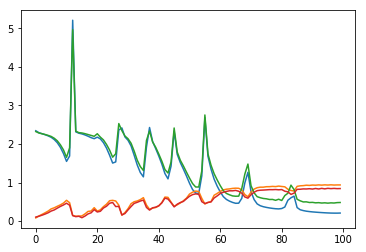

In [38]:
myfilter1 = np.random.normal(0,0.1,9*16).reshape(3,3,1,16)
myfilter2 = np.random.normal(0,0.1,16*16*18).reshape(4,4,16,18)

loss1,accuracy1,loss2, accuracy2 = train_CNN(temp,ytemp,temp1,ytemp1,myfilter1,myfilter2,fc1_neurons=20,num_class=10,alpha=0.1,iterations=100)    
pd.Series(loss1).plot()    
pd.Series(accuracy1).plot()
pd.Series(loss2).plot()    
pd.Series(accuracy2).plot()